In [1]:
!pip install pandas matplotlib numpy


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [3]:
df = pd.read_csv("Startdata.csv", delimiter=',')
print(df.head())
print(df.columns.tolist())

   Device_type            Timestamp Heart rate  Activity type Sleep stage  \
0  Apple Watch  20250602074248+0200         42              0       Awake   
1  Apple Watch  20250602074813+0200         58              1       Awake   
2  Apple Watch  20250602075146+0200         60              1       Awake   
3  Apple Watch  20250602075658+0200         75              0       Awake   
4  Apple Watch  20250602080402+0200         84              0       Awake   

   Coffee  
0       0  
1       0  
2       0  
3       0  
4       0  
['Device_type', 'Timestamp', 'Heart rate', 'Activity type', 'Sleep stage', 'Coffee']


### pre-preprocessing

In [4]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y%m%d%H%M%S%z", errors="coerce")
df["Heart rate"] = pd.to_numeric(df["Heart rate"], errors="coerce")
df["Activity type"] = df["Activity type"].astype("category")

In [5]:
# How many coffee values are there? 16
print((df["Coffee"] != 0).sum())

# Transform Coffee -> Caffeine left in body
half_life, dose = 5, 75
events, caffeine_left = [], []

for t, c in zip(df["Timestamp"], df["Coffee"]):
    events = [(et, d) for et, d in events if (t - et).total_seconds() < 24*3600]
    total = sum(d * 0.5 ** ((t - et).total_seconds() / 3600 / half_life) for et, d in events)
    if c == 1.0:
        events.append((t, dose))
        total += dose
    caffeine_left.append(total)

df["Caffeine"] = pd.Series(caffeine_left).round(3)

# Clean Caffeine Column
df["Caffeine"] = pd.to_numeric(df["Caffeine"], errors="coerce").fillna(0).astype(float)

# Example
# for ts, val in df.loc[df["Caffeine"] > 0, ["Timestamp", "Caffeine"]].values:
#     print(ts.strftime("%Y-%m-%d %H:%M"), val)



16
['Device_type', 'Timestamp', 'Heart rate', 'Activity type', 'Sleep stage', 'Coffee', 'Caffeine']


In [6]:
def plot_feature(feature, cat=False):

    # Ignore Missing Values
    f = df[feature]
    if cat: f = df[feature].astype("category").cat.add_categories("Unknown").fillna("Unknown")

    # Choose Color
    color_dict = {
    "Heart rate": "deepskyblue",
    "Caffeine": "brown",
    "Activity type": "darkorange",
    "Sleep stage": "purple"}
    color = color_dict.get(feature, "blue")

    # Plot
    fig, axs = plt.subplots(figsize=(14, 5))
    axs.plot(df["Timestamp"], f, color=color)
    axs.set_xlabel("Time", fontsize=16)
    axs.set_ylabel(f"{feature} Level", fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig(f"{feature}_over_time.png", dpi=300)
    plt.show()

# plot_feature("Caffeine")
# plot_feature('Heart rate')
# plot_feature('Activity type', True)

# 2. Exploratory Data Analysis
<!-- <h1 style="color:darkblue;">2. Exploratory Data Analysis</h1> -->

### Plot Activity-Type, Sleep-Stage counts 

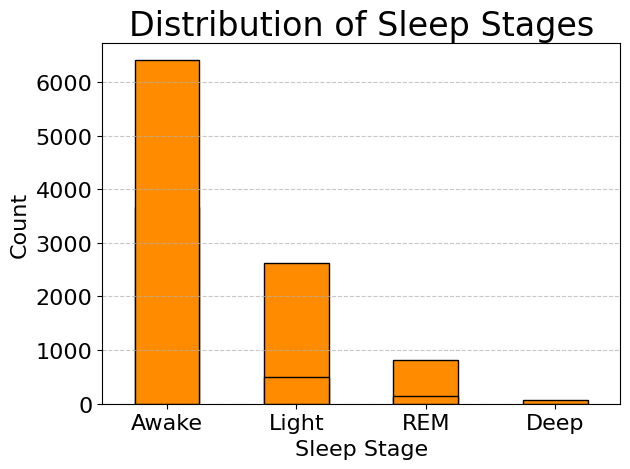

In [7]:
#Activity type
activity_counts = df["Activity type"].value_counts(dropna=False)
activity_counts.index = activity_counts.index.fillna("Missing")
activity_counts.plot(kind='bar', color='darkorange', edgecolor='black')
plt.xlabel("Activity Type", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Distribution of Activity Types", fontsize=24)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig(os.path.expanduser('~/Desktop/activity_type.png'), dpi=300)
# plt.show()

#Sleep stage
activity_counts = df["Sleep stage"].value_counts(dropna=False)
activity_counts.index = activity_counts.index.fillna("Missing")
activity_counts.plot(kind='bar', color='darkorange', edgecolor='black')
plt.xlabel("Sleep Stage", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Distribution of Sleep Stages", fontsize=24)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig(os.path.expanduser('~/Desktop/sleep_stage.png'), dpi=300)
# plt.show()


### Create various intervals (5min, 10min, 15min)

In [8]:
#Creating various intervals
def resample_df(df, interval="10min"):
    """
    Resample numerical and categorical columns in a time-indexed DataFrame.

    Parameters:
        df (pd.DataFrame): Input dataframe with a 'Timestamp' column.
        interval (str): Time interval string for resampling (e.g., '10min', '1H').

    Returns:
        pd.DataFrame: Resampled dataframe with 'Timestamp' as a column.
    """
    # Ensure Timestamp is parsed and set as index
    df = df.copy()
    df.columns = df.columns.str.strip()
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
    df["Heart rate"] = pd.to_numeric(df["Heart rate"], errors="coerce")
    df = df.set_index("Timestamp").sort_index()

    # Define columns
    numerical_cols = ["Heart rate"]
    categorical_cols = ["Activity type", "Sleep stage", "Caffeine"]

    # Convert categoricals to string to avoid numeric aggregation
    for col in categorical_cols:
        df[col] = df[col].astype(str)

    # Resample numericals using mean
    numerical_resampled = df[numerical_cols].resample(interval).mean()

    # Resample categoricals using mode
    categorical_resampled = pd.DataFrame(index=numerical_resampled.index)
    for col in categorical_cols:
        categorical_resampled[col] = df[col].resample(interval).agg(
            lambda x: x.mode().iloc[0] if not x.mode().empty else None
        )

    # Combine and reset index
    df_resampled = pd.concat([numerical_resampled, categorical_resampled], axis=1).reset_index()

    return df_resampled

df_5min = resample_df(df, "5min")
df_10min = resample_df(df, "10min")
df_15min = resample_df(df, "15min")


['Device_type', 'Timestamp', 'Heart rate', 'Activity type', 'Sleep stage', 'Coffee', 'Caffeine']


['Device_type', 'Timestamp', 'Heart rate', 'Activity type', 'Sleep stage', 'Coffee', 'Caffeine']


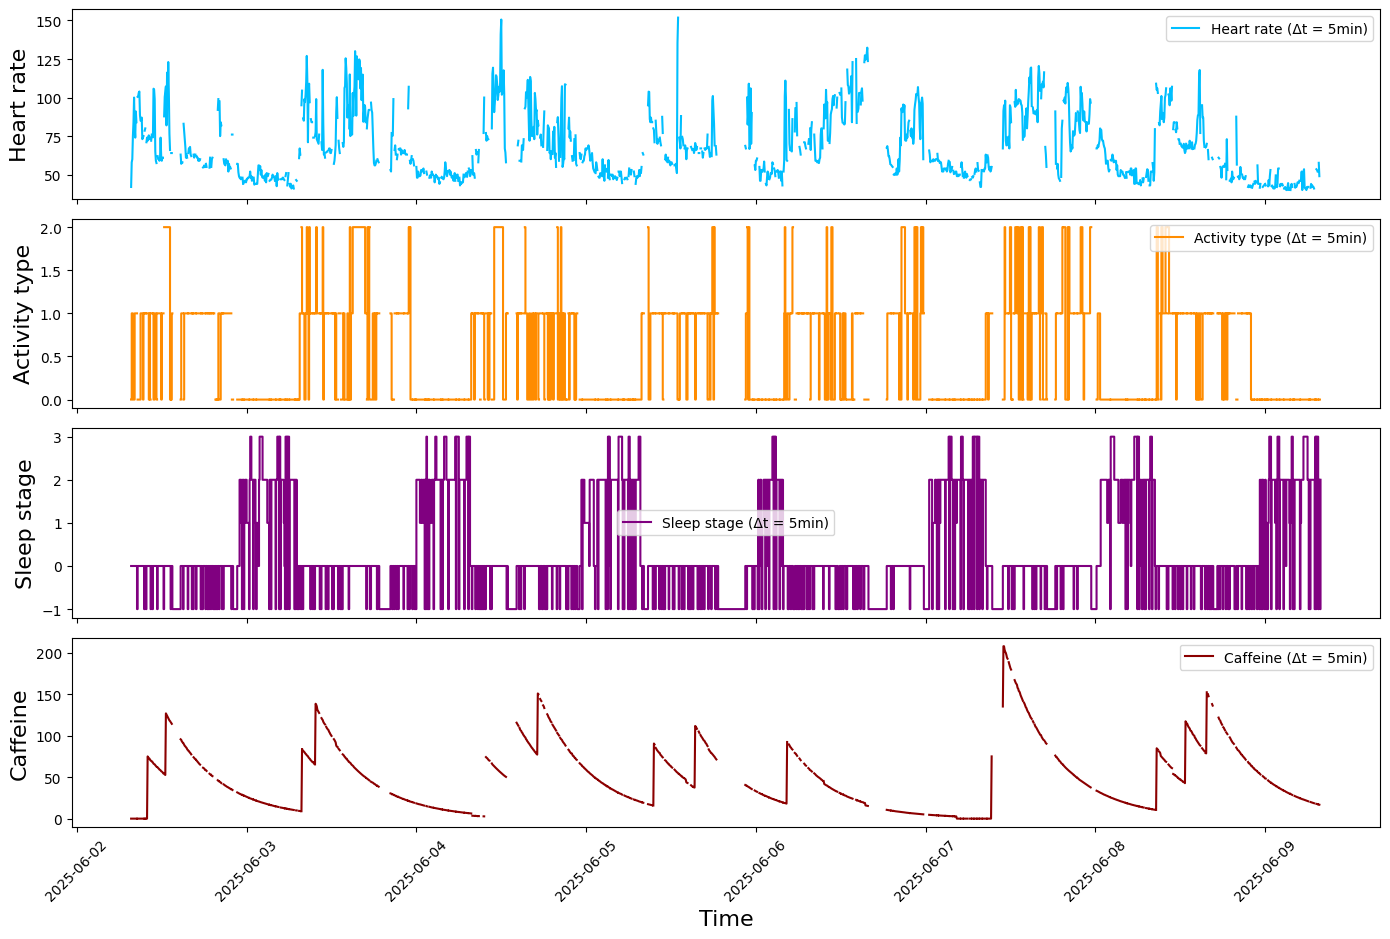

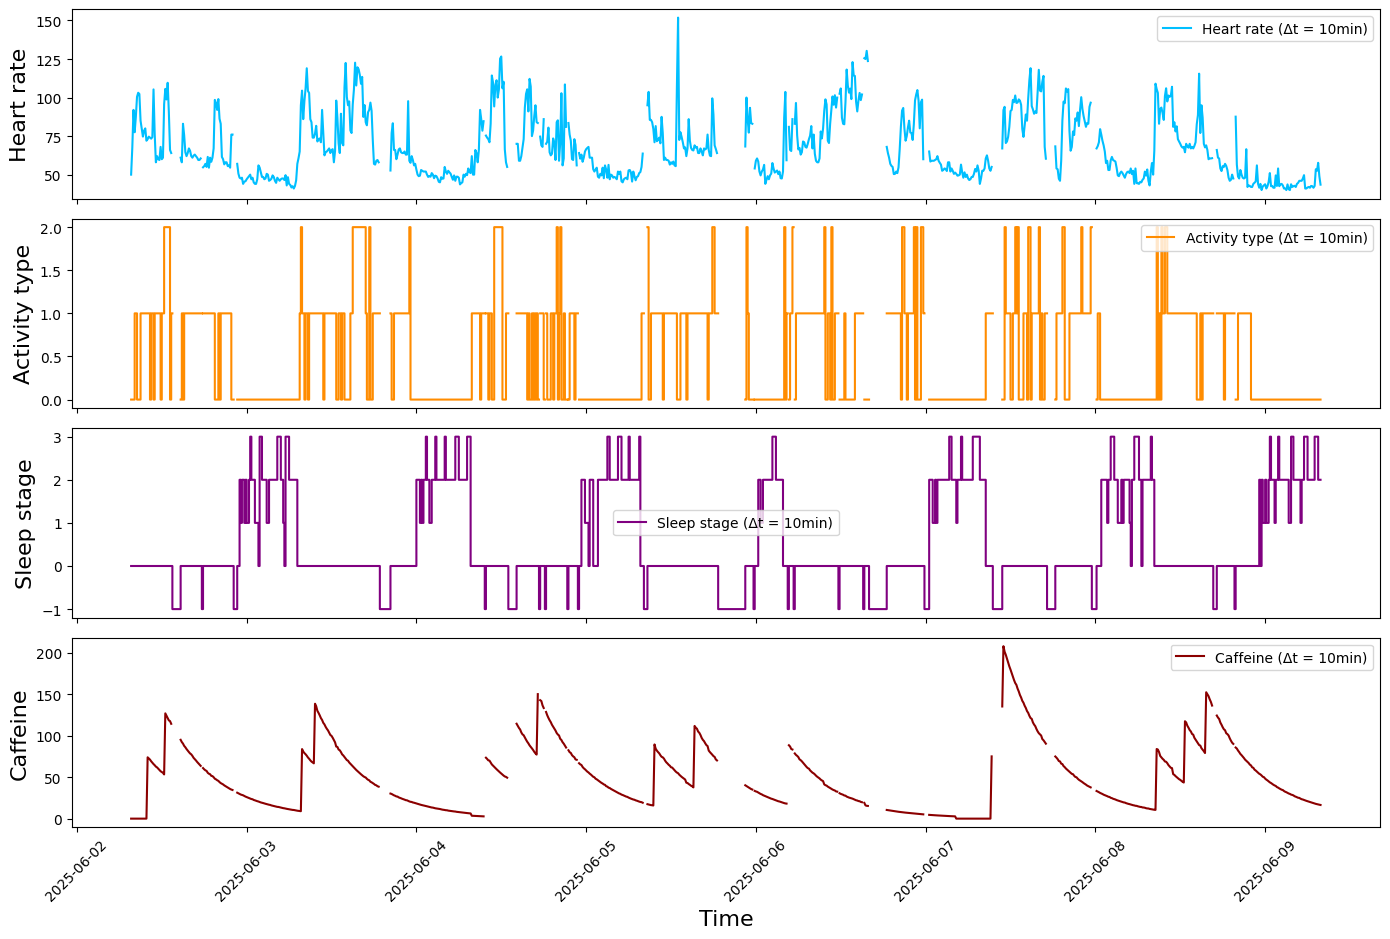

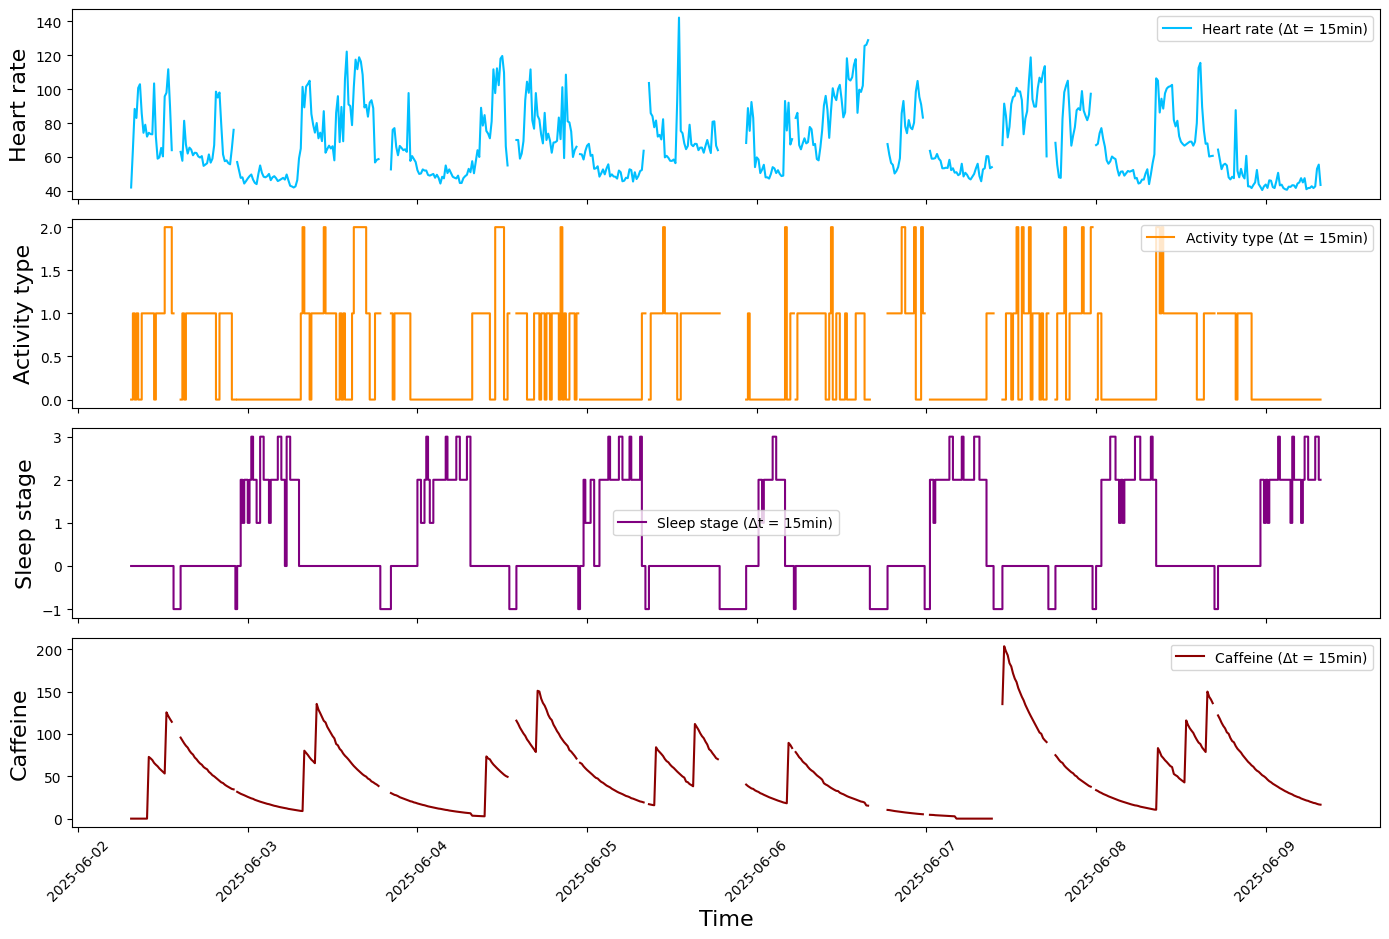

In [9]:
def plot_sensor_overview(df_resampled, interval_label="10min", save_path="/Users/dora/Desktop/timeseries_plot.png"):
    """
    Plots 4 sensor/categorical measurements over time in subplots.
    
    Parameters:
        df_resampled (pd.DataFrame): Resampled dataframe with 'Timestamp' as a column.
        interval_label (str): Label for the time interval (e.g., '10min') to show in the title and legends.
        save_path (str): File path to save the resulting plot image.
    """

    # Ensure timestamp is in datetime format and set as index
    df_resampled = df_resampled.copy()
    df_resampled["Timestamp"] = pd.to_datetime(df_resampled["Timestamp"], errors="coerce")
    df_resampled = df_resampled.set_index("Timestamp")

    # Clean caffeine column
    df_resampled["Caffeine"] = pd.to_numeric(df_resampled["Caffeine"], errors="coerce")

    # Set up figure and axes
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 10), sharex=True)

    # Plot 1: Heart rate
    axs[0].plot(df_resampled.index,
                df_resampled["Heart rate"],
                label=f"Heart rate (Δt = {interval_label})",
                color='deepskyblue')
    axs[0].set_ylabel("Heart rate", fontsize=16)
    axs[0].legend()

    # Plot 2: Activity type
    axs[1].plot(df_resampled.index,
                pd.to_numeric(df_resampled["Activity type"], errors='coerce'),
                drawstyle='steps-post',
                label=f"Activity type (Δt = {interval_label})",
                color='darkorange')
    axs[1].set_ylabel("Activity type", fontsize=16)
    axs[1].legend()

    # Plot 3: Sleep stage
    axs[2].plot(df_resampled.index,
                df_resampled["Sleep stage"].astype("category").cat.codes,
                drawstyle='steps-post',
                label=f"Sleep stage (Δt = {interval_label})",
                color='purple')
    axs[2].set_ylabel("Sleep stage", fontsize=16)
    axs[2].legend()

    # Plot 4: Caffeine
    axs[3].plot(df_resampled.index,
                df_resampled["Caffeine"],
                label=f"Caffeine (Δt = {interval_label})",
                color='darkred')
    axs[3].set_ylabel("Caffeine", fontsize=16)
    axs[3].legend()

    # Final formatting
    axs[-1].set_xlabel("Time", fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leaves space for suptitle
    plt.savefig(save_path, dpi=300)
    # plt.show()

plot_sensor_overview(df_5min, interval_label="5min", save_path=os.path.expanduser('~/Desktop/5.png'))
plot_sensor_overview(df_10min, interval_label="10min", save_path=os.path.expanduser('~/Desktop/10.png'))
plot_sensor_overview(df_15min, interval_label="15min", save_path=os.path.expanduser('~/Desktop/15.png'))

In [10]:
#For further anlysis we use df_10min
df = df_10min
print(df.isna().sum())

Timestamp          0
Heart rate       105
Activity type    105
Sleep stage      105
Caffeine         105
dtype: int64


# 3. Data Preprocessing
<!-- <h1 style="color:darkblue;">3. Data Preprocessing</h1> -->

### Data Cleaning

In [11]:
df["Caffeine"] = pd.to_numeric(df["Caffeine"], errors="coerce")

['Timestamp', 'Heart rate', 'Activity type', 'Sleep stage', 'Caffeine']


### Outlier Removal

In [12]:
lower, upper = df['Heart rate'].quantile([0.01, 0.99])
df['Heart rate'] = df['Heart rate'].clip(lower, upper)

### Imputation

In [13]:
# Linear Interpolation

# Heart rate
# plot_feature('Heart rate')
df['Heart rate'] = df['Heart rate'].interpolate()
# plot_feature('Heart rate')

# Caffeine
# plot_feature('Caffeine')
df['Caffeine'] = df['Caffeine'].interpolate()
# plot_feature('Caffeine')

# Activity Type
# plot_feature('Activity type', True)
df['Activity type'] = df['Activity type'].fillna(df['Activity type'].mode()[0])
# plot_feature('Activity type', True)

### Kalman Filter (smooths out heart rate)

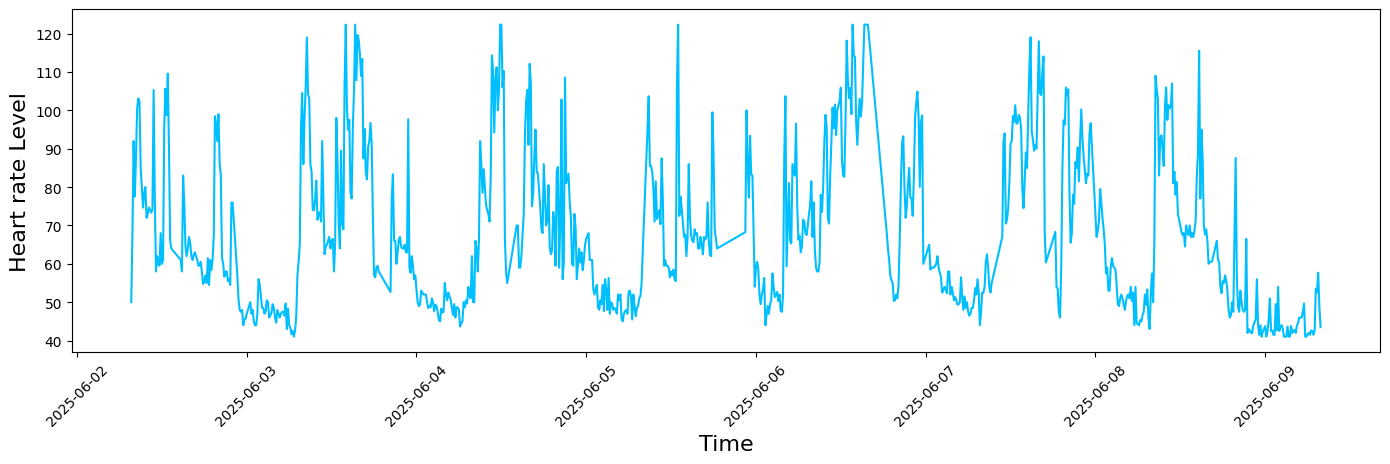

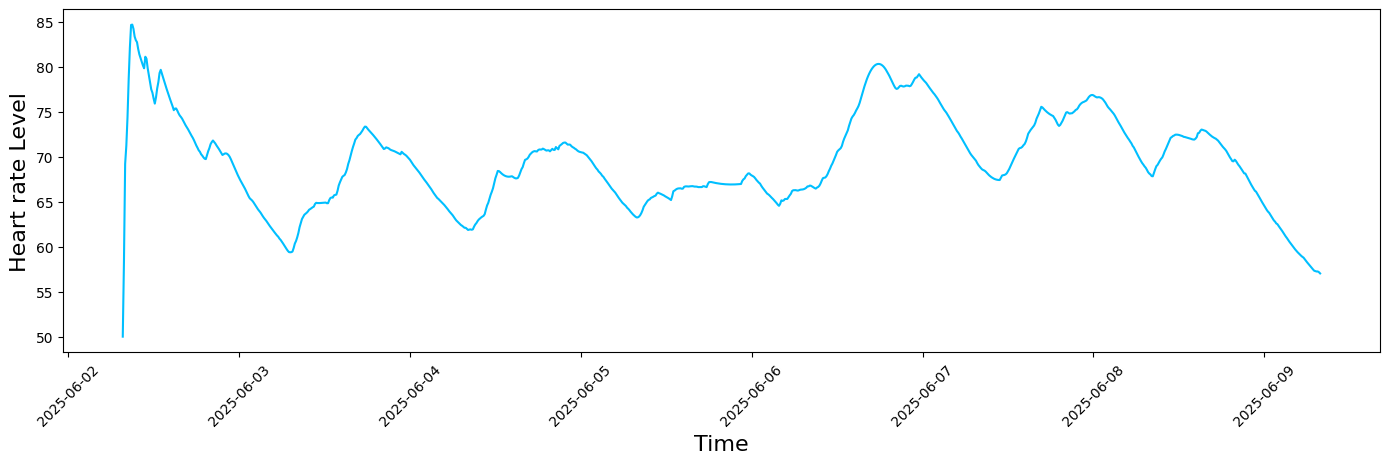

In [14]:
def kalman_1d(zs, Q=1e-5, R=0.1):
    x = zs[0]
    P = 1.0
    filtered = []
    for z in zs:
        # Predict
        P += Q
        # Update
        K = P / (P + R)
        x += K * (z - x)
        P *= (1 - K)
        filtered.append(x)
    return filtered

plot_feature('Heart rate')
df['Heart rate'] = kalman_1d(df['Heart rate'].values)
plot_feature('Heart rate')

# 4. Feature Engineering

### Time -> (Day-of-Week, Hour, Minute)

In [15]:
df["hour"] = df["Timestamp"].dt.hour
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)  # Cyclic
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)  # Cyclic
df["minute"] = df["Timestamp"].dt.minute
df["day_of_week"] = df["Timestamp"].dt.dayofweek 

### Caffeine -> (Hours-since-Caffeine)

In [45]:
# Hours since Caffeine intake
# last, hours_since = None, []

# for t, c in zip(df["Timestamp"], df["Coffee"]):
#     last = t if c == 1 else last
#     hours_since.append(0 if c == 1 else ((t - last).total_seconds() / 3600) if last else np.nan)

# df["hours_since_caffeine"] = hours_since

### Heart Rate -> (rolling_mean/std/min/max/range, change, percent-change, low-medium-high)

In [17]:
n = 5
df["hr_rolling_mean"] = df["Heart rate"].rolling(window=n, min_periods=1).mean()  # smooths heart rate (trend)
df["hr_rolling_std"] = df["Heart rate"].rolling(window=n, min_periods=1).std().fillna(0)    # heart rate variability (volatility)
df["hr_min"] = df["Heart rate"].rolling(window=n, min_periods=1).min()         # rolling minimum over n points
df["hr_max"] = df["Heart rate"].rolling(window=n, min_periods=1).max()         # rolling maximum over n points
df["hr_range"] = df["hr_max"] - df["hr_min"]                                   # range in n-point window
df["hr_diff"] = df["Heart rate"].diff().fillna(0)                              # immediate heart rate change
df["hr_pct_change"] = df["Heart rate"].pct_change().fillna(0)                  # relative heart rate change (%)
df["hr_level"] = pd.cut(df["Heart rate"], bins=[0, 60, 90, np.inf], labels=["low", "medium", "high"]) 

### Sleep stage -> categorical

In [18]:
df["Sleep stage"] = df["Sleep stage"].astype("category").cat.codes

## Feature Selection

In [43]:
# Overview
features = df.columns.tolist()
features = [
    'Timestamp', "hour", "hour_sin", "hour_cos", "minute", "day_of_week",
    'Heart rate', "hr_rolling_mean", "hr_rolling_std", "hr_min", "hr_max", "hr_range", "hr_diff", "hr_pct_change", "hr_level",
    'Activity type', 
    'Sleep stage',
    'Caffeine']

# Define
target_feature = 'Sleep stage'
time_features = ['Timestamp', "hour", "hour_sin", "hour_cos", "minute", "day_of_week"]

# Select
class_features = df.drop(columns=time_features + [target_feature])
lstm_features = df.drop(columns=['Timestamp'] + [target_feature])

In [44]:
# Print NaN values
for feature in features:
    nan_count = df[feature].isna().sum()
    print(f" {nan_count} NaNs: {feature}")

 0 NaNs: Timestamp
 0 NaNs: hour
 0 NaNs: hour_sin
 0 NaNs: hour_cos
 0 NaNs: minute
 0 NaNs: day_of_week
 0 NaNs: Heart rate
 0 NaNs: hr_rolling_mean
 0 NaNs: hr_rolling_std
 0 NaNs: hr_min
 0 NaNs: hr_max
 0 NaNs: hr_range
 0 NaNs: hr_diff
 0 NaNs: hr_pct_change
 0 NaNs: hr_level
 0 NaNs: Activity type
 0 NaNs: Sleep stage
 0 NaNs: Caffeine


# 5. Model: Random Forest